Generate FEM solution for 2D plane stress problem

* Fix the top boundary, apply random loading at bottom boundary
* Output dirich_idx, dirich_value; traction_idx, traction_value; bodyforce; solution; materials (E, v)
* The unit is GPa
* Please note that the node numbering in FEM and CNN is reverse in y direction

In [1]:
import meshio
import numpy as np
import matplotlib.pyplot as plt
import gaussian_random_fields as gr
import random
import h5py

In [2]:
class MeshSquareFEM():
    """ Handle a simple square mesh with quad elements
    0: background square
    
    Parameters:
        size: length of the square plate
        nnode_edge: number of nodes along edges of the plate
    """

    def __init__(self, size, nnode_edge, outfile = None):
        self.size = size
        self.nnode_edge = nnode_edge
        self.node_list = np.arange(nnode_edge*nnode_edge)
        self.mesh = None
        self.mesh = self.generate_mesh()
        self.generate_node_index()
        
        if outfile is not None:
            self.save_mesh(outfile)

    def generate_mesh(self):
        x = np.linspace(-self.size/2,self.size/2,self.nnode_edge, dtype=np.float32)
        y = np.linspace(-self.size/2,self.size/2,self.nnode_edge, dtype=np.float32)
        ms_x, ms_y = np.meshgrid(x,y)
        x = np.ravel(ms_x).reshape(-1,1)
        y = np.ravel(ms_y).reshape(-1,1)
        z = np.zeros_like(x, dtype=np.float32)
        points = np.concatenate((x,y,z),axis=1)
        n_element = (self.nnode_edge-1)*(self.nnode_edge-1)
        nodes = np.linspace(0,points.shape[0],points.shape[0],endpoint=False,dtype=int).reshape(self.nnode_edge,self.nnode_edge)
        cells = np.zeros((n_element,4),dtype=int)
        cells[:,0] = np.ravel(nodes[:self.nnode_edge-1,:self.nnode_edge-1])
        cells[:,1] = np.ravel(nodes[:self.nnode_edge-1,1:])
        cells[:,2] = np.ravel(nodes[1:,1:])
        cells[:,3] = np.ravel(nodes[1:,:self.nnode_edge-1])
        return meshio.Mesh(points, [("quad",cells)])

    def generate_node_index(self):
        '''Generate node index matrix that indicate boundary (True) or internal nodes (False)'''
        node_index = []
        top = []
        bottom = []
        left = []
        right = []
        
        for pt in self.mesh.points:
            temp_bool = [False, False, False, False, False] # Top, Bottom, Left, Right, Boundary
            if (np.isclose(pt[0],-self.size/2)):
                temp_bool[2], temp_bool[4] = True, True
            if (np.isclose(pt[0],self.size/2)):
                temp_bool[3], temp_bool[4] = True, True
            if (np.isclose(pt[1],self.size/2)):
                temp_bool[0], temp_bool[4] = True, True
            if (np.isclose(pt[1],-self.size/2)):
                temp_bool[1], temp_bool[4] = True, True
            
            top.append(temp_bool[0])
            bottom.append(temp_bool[1])
            left.append(temp_bool[2])
            right.append(temp_bool[3])
            node_index.append(temp_bool[4])

        self.node_top = self.node_list[top]
        self.node_left = self.node_list[left]
        self.node_right = self.node_list[right]
        self.node_bottom = self.node_list[bottom]
        self.node_essential = self.node_list[top] # apply essential boundary at the top boundary
        self.node_internal = self.node_list[np.invert(top)]

        self.dof_essential = np.zeros((2*self.node_essential.shape[0],), dtype=int) 
        self.dof_internal = np.zeros((2*self.node_internal.shape[0],), dtype=int) 
        self.dof_essential[0::2] = 2*self.node_essential
        self.dof_essential[1::2] = 2*self.node_essential+1
        self.dof_internal[0::2] = 2*self.node_internal
        self.dof_internal[1::2] = 2*self.node_internal+1
    
    def shapefunc(self, p):
        # shape function
        N = 0.25*np.array([[(1-p[0])*(1-p[1])],
                           [(1+p[0])*(1-p[1])],
                           [(1+p[0])*(1+p[1])],
                           [(1-p[0])*(1+p[1])]])

        dNdp = 0.25*np.array([[-(1-p[1]), -(1-p[0])],
                              [(1-p[1]), -(1+p[0])],
                              [(1+p[1]), (1+p[0])],
                              [-(1+p[1]), (1-p[0])]])
        return N, dNdp

    def save_mesh(self,outfile = 'mesh_square.vtk'):
        self.mesh.write(outfile)

In [3]:
class GridFEM():
    '''
    Note: the n should be the number of elements along edges, e.g., 
    there are (n-1)*(n-1) internal grid points 
    '''
    def __init__(self, n_elem, size = 2):
        self.size = size
        self.n = n_elem
        self.qpts = np.array([[-1, 1, 1, -1], [-1, -1, 1, 1]])/np.sqrt(3) #[2x4]
        self.d = np.zeros(2*(n_elem+1)*(n_elem+1))
        self.grid = MeshSquareFEM(size, nnode_edge=n_elem+1)
        
    def CreateA(self):
        '''
        Stiffness matrix, input material property, return A_F and A_EF 
        ''' 
        A = np.zeros((2*(self.n+1)*(self.n+1),2*(self.n+1)*(self.n+1)))
        for i, c in enumerate(self.grid.mesh.cells_dict['quad']):
            xe = self.grid.mesh.points[c,:].T[:2,:] #[2x4]
            E = self.grid.mesh.cell_data['E'][i]
            v = self.grid.mesh.cell_data['v'][i]
            D = E/(1.-v*v)*np.array([[1., v, 0.], [v, 1., 0.], [0., 0., (1.-v)/2.]]) # plane stress
            Ke = np.zeros((8,8))
            for q in self.qpts.T:
                [_,dNdp] = self.grid.shapefunc(q)
                J = np.dot(xe, dNdp) #[2x2]
                dNdx = np.dot(dNdp, np.linalg.inv(J)) #[4x2]
                B = np.zeros((3,8))
                B[0, 0::2] = dNdx[:,0]
                B[1, 1::2] = dNdx[:,1]
                B[2, 0::2] = dNdx[:,1]
                B[2, 1::2] = dNdx[:,0]
                Ke += np.linalg.det(J)*np.dot(B.T,np.dot(D,B))
            
            cc = np.zeros((8,), dtype=int)
            cc[0::2] = 2*c
            cc[1::2] = 2*c+1
            A[np.ix_(cc,cc)] += Ke
            
        return A, A[np.ix_(self.grid.dof_internal,self.grid.dof_internal)], A[np.ix_(self.grid.dof_essential,self.grid.dof_internal)]

    def UpdateBodyForce(self, f = None):
        '''
        Return the rhs internal sourcing term with modification from finite element term
        '''
        ff = np.zeros_like(f)
        for c in self.grid.mesh.cells_dict['quad']:
            xe = self.grid.mesh.points[c,:].T[:2,:] #[2x4]
            for q in self.qpts.T:
                [N,dNdp] = self.grid.shapefunc(q)
                J = np.dot(xe, dNdp) #[2x2]
                ff[2*c] += np.linalg.det(J)*np.dot(N,np.dot(N.T,f[2*c])) #[4x1]
                ff[2*c+1] += np.linalg.det(J)*np.dot(N,np.dot(N.T,f[2*c+1])) #[4x1]
        return ff
    
    def TractionBottomBC(self, f, bc_value):
        '''
        Bottom boundary node: 1,2,3,4,5,6,7 ... 
        bc_value has the same shape as f
        '''
        connection = np.stack((self.grid.node_bottom[:-1],self.grid.node_bottom[1:]), axis=-1)
        for c in connection:
            xe = self.grid.mesh.points[c,:][:,:2] #[2x2]
            le = np.linalg.norm(xe[1,:]-xe[0,:])
            for q in [1./np.sqrt(3), -1./np.sqrt(3)]:
                N = 0.5*np.array([1-q, 1+q])
                f[2*c] += np.dot(N,np.dot(N.T,bc_value[2*c]))*le/2 #[2x1]
                f[2*c+1] += np.dot(N,np.dot(N.T,bc_value[2*c+1]))*le/2 #[2x1]
        return f, f[self.grid.dof_internal]

    def GaussianRF(self, n, a_interval):
        alpha = random.uniform(2,5)
        a0, a1 = a_interval[0],a_interval[1]
        field = gr.gaussian_random_field(alpha=alpha, size=n, flag_normalize=False)
        f_min, f_max = np.min(field), np.max(field)
        rf = (a1-a0)*(field-f_min)/(f_max-f_min)+a0
        return rf

    def Solve(self, material, traction_value=None, f=None):
        '''
        Solve the linear equation system
        material: shape is [n, n, 2]
        f and traction_value shape are [2 x (n+1) x (n+1)]
        '''
        if(f is None):
            f = np.zeros(2*(self.n+1)*(self.n+1))
            f[0::2] = self.GaussianRF(self.n+1, [1,5]).reshape((self.n+1)*(self.n+1))
            f[1::2] = self.GaussianRF(self.n+1, [1,5]).reshape((self.n+1)*(self.n+1))

        # create cell data
        self.grid.mesh.cell_data['E'] = material[:, :, 0].reshape(self.n*self.n)
        self.grid.mesh.cell_data['v'] = material[:, :, 1].reshape(self.n*self.n)

        self.f = self.UpdateBodyForce(f)
        self.A, self.A_F, _ = self.CreateA()
        self.b, self.b_F = self.TractionBottomBC(self.f, traction_value)
        d_F = np.linalg.solve(self.A_F, self.b_F)
        self.d[self.grid.dof_internal] = d_F

    def PlotSolution(self, field = None):
        '''Default is to plot the solution field'''
        if(field is None):
            field = self.d
        
        size = int(np.sqrt(field.shape[0]/2))
        self.x_disp = field[0::2].reshape((size, size))
        self.y_disp = field[1::2].reshape((size, size))

        fig = plt.figure()

        fig.add_subplot(1,2,1)
        im1 = plt.imshow(self.x_disp, origin='lower')
        plt.axis('off')
        plt.title('X')
        plt.colorbar(im1)

        fig.add_subplot(1,2,2)
        im2 = plt.imshow(self.y_disp, origin='lower')
        plt.axis('off')
        plt.title('Y')
        plt.colorbar(im2)

        plt.tight_layout()
        plt.show()

In [4]:
n_elem = 2**5
prob = GridFEM(n_elem)

E1, v1, E2, v2 = 69, 0.34, 20, 0.3
material = np.zeros((n_elem, n_elem, 2)) 
# top right material-1
# else material-2
material[:, :, 0] = E2
material[:, :, 1] = v2
n_part = int(1.42/2*n_elem)
material[-n_part:, -n_part:, 0] = E1
material[-n_part:, -n_part:, 1] = v1

bc_value = np.zeros((2*(n_elem+1)*(n_elem+1),))
bc_value[2*prob.grid.node_bottom] = -2 # apply 2GPa stress 

# assign body force to material-2
f = np.zeros(2*(n_elem+1)*(n_elem+1))
#n_part = int(1.42/2*(n_elem+1))
#body_force = 1e3*np.ones(shape=(n_elem+1,n_elem+1))
#body_force[-n_part:, -n_part:] = 0.
#f[0::2] = body_force.reshape((n_elem+1)*(n_elem+1))

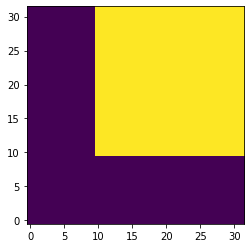

In [5]:
plt.imshow(material[:,:,0].reshape(n_elem, n_elem), origin='lower')

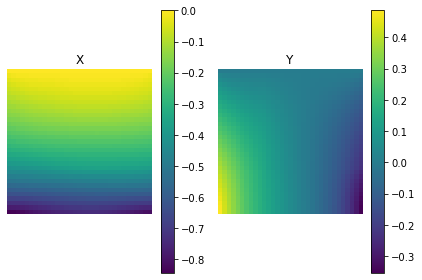

In [6]:
prob.Solve(material, bc_value, f)
prob.PlotSolution()

In [7]:
print("Displacement range in x-axis is:", np.min(prob.x_disp), np.max(prob.x_disp))
print("Displacement range in y-axis is:", np.min(prob.y_disp), np.max(prob.y_disp))

Displacement range in x-axis is: -0.8435560715181898 0.0
Displacement range in y-axis is: -0.3534099883382081 0.4859488751306582


In [8]:
def loading_type1(n):
    '''Loading: fix top boundary at all dofs; apply random loading at bottom boundary'''
    dirich_idx = np.ones((n, n, 2))
    dirich_idx[-1, :, :] = 0.
    dirich_value = np.zeros_like(dirich_idx)
    dirich_value[-1, :, :] = 0.0

    # define traction boundary, 1.0 traction boundary; 0 else
    traction_idx = np.zeros((n, n, 2))
    traction_idx[0,  :,  :] = 1. 
    traction_value = np.zeros_like(traction_idx)
    #f = 20*np.random.rand((n,2))-10 # -10GPa ~ 10GPa
    #traction_value[0,:,:] = f
    #f = [1, -1] 
    f = 20*np.random.rand(2)-10 # -10GPa ~ 10GPa
    traction_value[0,:,0] = f[0]
    traction_value[0,:,1] = f[1]

    return dirich_idx, dirich_value, traction_idx, traction_value

In [9]:
def combine_vectors(v):
    '''combine vectors v (n, n, 2) to (2xnxn)'''
    _, n, _ = v.shape
    u = np.zeros(shape=(2*n*n,))
    u[0::2] = v[:, :, 0].reshape(n*n)
    u[1::2] = v[:, :, 1].reshape(n*n)
    return u

In [10]:
def split_vectors(v):
    '''split vectors v from (2xnxn) to (n, n, 2) '''
    nn = v.shape[0]
    n = int(np.sqrt(nn/2))
    u = np.zeros(shape=(n, n, 2))
    u[:,:,0] = v[0::2].reshape(n, n)
    u[:,:,1] = v[1::2].reshape(n, n)
    return u

In [11]:
# Create dataset
# dataset contains: dirich_idx~2xnxn, dirich_value~2xnxn, traction_idx~2xnxn, traction_value~2xnxn, material~2x(n-1)x(n-1), f~2xnxn, solution~2xnxn

dataset = {}
n_data = 20
dirich_idx_data = np.zeros((n_data, n_elem+1, n_elem+1, 2))
dirich_value_data = np.zeros((n_data, n_elem+1, n_elem+1, 2))
traction_idx_data = np.zeros((n_data, n_elem+1, n_elem+1, 2))
traction_value_data = np.zeros((n_data, n_elem+1, n_elem+1, 2))
material_data = np.zeros((n_data, n_elem, n_elem, 2))
f_data = np.zeros((n_data, n_elem+1, n_elem+1, 2))
u_data = np.zeros((n_data, n_elem+1, n_elem+1, 2))
for i in range(n_data):
    # define boundary conditions
    dirich_idx, dirich_value, traction_idx, traction_value = loading_type1(n_elem+1)
    dirich_idx_data[i] = dirich_idx
    dirich_value_data[i] = dirich_value
    traction_idx_data[i] = traction_idx
    traction_value_data[i] = traction_value
    
    # create material field, E~[1,5]GPa
    #E_field, v_field = 6*np.ones((n_elem, n_elem)), 0.32*np.ones((n_elem, n_elem))
    #E_field, v_field = prob.GaussianRF(n_elem, [1e6, 100e9]), 0.32*np.ones((n_elem, n_elem))
    E_field, v_field = prob.GaussianRF(n_elem, [1, 5]), prob.GaussianRF(n_elem, [0.25, 0.45])
    material = np.stack((E_field, v_field), axis=2)
    material_data[i] = material 

    # define body force field
    #f1, f2 = np.zeros((n_elem+1,n_elem+1)), np.zeros((n_elem+1,n_elem+1))
    #f1, f2 = np.ones((n_elem+1,n_elem+1)), -np.ones((n_elem+1,n_elem+1))
    f1, f2 = prob.GaussianRF(n_elem+1, [-5, 5]), prob.GaussianRF(n_elem+1, [-5, 5])
    f_data[i] = np.stack((f1, f2), axis=2)
    f = combine_vectors(f_data[i])

    # solve the problem
    prob.Solve(material, combine_vectors(traction_value), f)
    u_data[i] = split_vectors(prob.d)
    print("Problem #-"+str(i)+" solved")

Problem #-0 solved
Problem #-1 solved
Problem #-2 solved
Problem #-3 solved
Problem #-4 solved
Problem #-5 solved
Problem #-6 solved
Problem #-7 solved
Problem #-8 solved
Problem #-9 solved
Problem #-10 solved
Problem #-11 solved
Problem #-12 solved
Problem #-13 solved
Problem #-14 solved
Problem #-15 solved
Problem #-16 solved
Problem #-17 solved
Problem #-18 solved
Problem #-19 solved


In [12]:
dataset['dirich_idx'] = dirich_idx_data
dataset['dirich_value'] = dirich_value_data
dataset['traction_idx'] = traction_idx_data
dataset['traction_value'] = traction_value_data
dataset['material'] = material_data
dataset['body_force'] = f_data
dataset['solution'] = u_data

with h5py.File("elasticity_type1_2d_33x33.h5", "w") as hf:
    for key, item in dataset.items():
        hf[key] = item

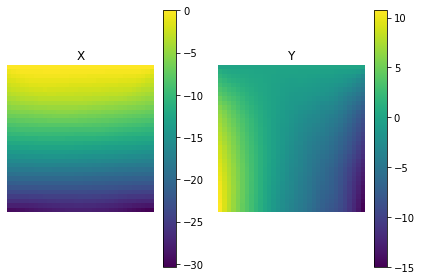

In [13]:
prob.PlotSolution()

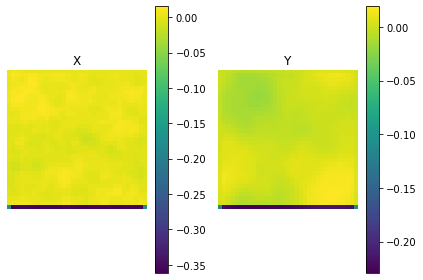

In [14]:
prob.PlotSolution(prob.b)